In [1]:
from matplotlib import image
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression, BayesianRidge

import numpy as np
from PIL import Image

### Просто функции, которые понадобятся в дальнейшем

In [2]:
def vertical_gradient(im, c=1):
    """Функция принимает на вход grayscale array и параметр c - то, через сколько пикселей считается вертикальный градиент"""
    size = im.shape
    ar = np.zeros((size[0]-c, size[1]))
    for j in range(size[1]):
        for i in range(size[0]-c):
            ar[i][j] = abs(im[i+c][j]-im[i][j])
    return ar

def horizontal_gradient(im, c=1):
    """Функция принимает на вход grayscale array и параметр c - то, через сколько пикселей считается горизонтальный градиент"""
    size = im.shape
    ar = np.zeros((size[0], size[1]-c))
    for i in range(size[1]-c):
        for j in range(size[0]):
            ar[j][i] = abs(im[j][i+c]-im[j][i])
    return ar

In [3]:
def split_by_c(p, c=70):
    """Функция нужна для красивого отображения точек, которые мы хотим взять в выборку для построения прямой"""
    p_c = p.copy()
    p_c[p_c <= c] = 0
    p_c[p_c > c] = 1
    return p_c

def return_train_from_ar_gradient(ar_grad, gr=70):
    """Возвращает по заданной границе точки, которые пойдут для построения прямых"""
    ar = []
    for i in range(ar_grad.shape[0]):
        for j in range(ar_grad.shape[1]):
            if ar_grad[i][j] > gr:
                ar.append([i, j])
    p = np.array(ar)
    return p

def coefs(p, model='simple'):
    """Возвращает коэффициенты прямой, у которой минимальна сумма квадратов расстояний от точек выборки до прямой"""
    x = p[:, 0]
    y = p[:, 1]

    x_ = []
    for i in range(len(x)):
        x_.append([x[i]])
    if model == 'simple':
        model = LinearRegression()
    else:
        model = BayesianRidge()
    model.fit(x_, y)
    return model.coef_[0], model.intercept_

In [4]:
def show_result(line, name='images_all\grain_1.png', color='green', showtrain=True, model='simple'):
    """Красивый вывод полученных прямых и картинки. Если showtrain True, то точки, на которых обучалась прямая 
    показываются, иначе показываются только прямые"""
    f = coefs(line, model=model)
    if showtrain:
        plt.plot(line[:, 1], line[:, 0],  'bo', markersize=2)
    def line_(x):
        return f[0]*(x) + f[1]
    plt.plot(line_(line[:, 0]), line[:, 0], c=color)

    plt.imshow(Image.open(name))

## Картинка, для которой попробуем определить границы

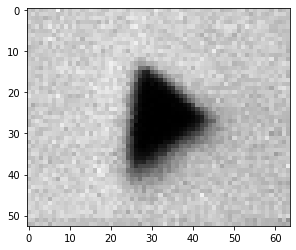

In [5]:
im = np.array(Image.open('images_all\grain_1.png').convert('L'))
im = im.astype(int)
plt.imshow(Image.open('images_all\grain_1.png'))

## Вертикальный градиент

Если будем считать градиент у соседних клеток (c=1)

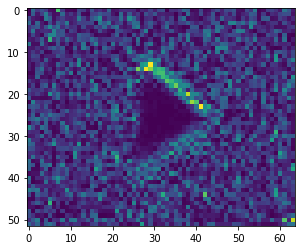

In [6]:
plt.imshow(vertical_gradient(im, c=1))
plt.show()

То видим, что много есть шума - то есть соседние клетки границ переходят достаточно плавно. Возьмём побольше пикселей

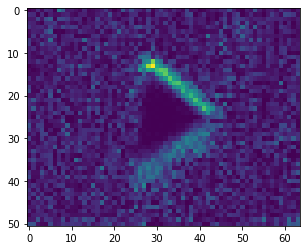

In [7]:
plt.imshow(vertical_gradient(im, c=2))
plt.show()

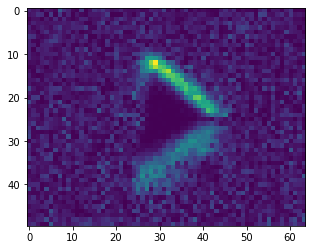

In [8]:
plt.imshow(vertical_gradient(im, c=3))
plt.show()

Сразу видим проблему - может быть на одном из градиентов не видно границы из-за её параллельности какой-то оси.

Тут видно, что для этого вида градиента бороться за третью линию нет смысла - она слишком блика к параллельной оси.

Возьмём c=2, кажется так уже меньше шума вокруг и границы не сильно расплылись

## Горизонтальный градиент

Тот же самый подбор параметра c - разности расстояний между пикселями для подсчёта градиента

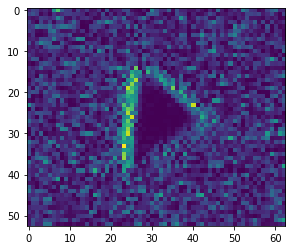

In [9]:
plt.imshow(horizontal_gradient(im, c=1))
plt.show()

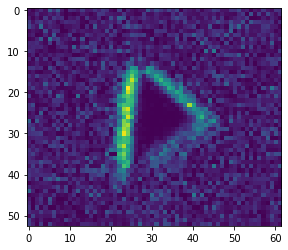

In [10]:
plt.imshow(horizontal_gradient(im, c=2))
plt.show()

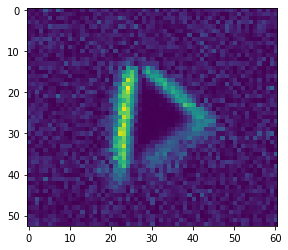

In [11]:
plt.imshow(horizontal_gradient(im, c=3))
plt.show()

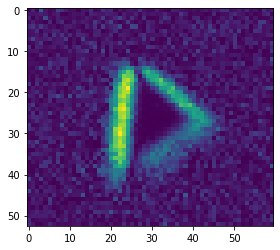

In [12]:
plt.imshow(horizontal_gradient(im, c=
                               4))
plt.show()

In [13]:
points_vert = vertical_gradient(im, c=4)
points_hor = horizontal_gradient(im, c=2)

Тут же я предлагаю побороться за все три линии

Хорошо, мы получили значение градиента для каждого пикселя, теперь нужно подобрать ещё один гиперпараметр - порог градиента - значение, если градиент пикселя выше которого, то мы будем использовать этот пиксель для построения прямой.

Для этого у меня функция split_by_c

(переформулировать))

Как я подбираю эту границу - смотрю когда примерно перестаёт появляться шум

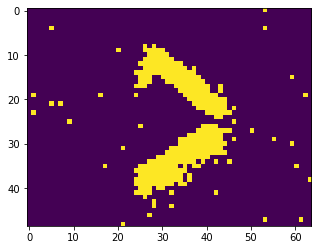

In [14]:
plt.imshow(split_by_c(points_vert, 40))

тут еще шумно - 40 слишком мало

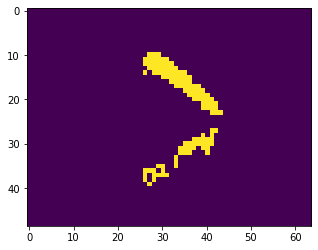

In [15]:
plt.imshow(split_by_c(points_vert, 85))

думаю уже нормально)

для горизонтальной:

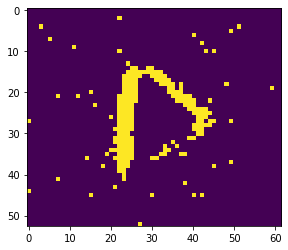

In [16]:
plt.imshow(split_by_c(points_hor, 40))

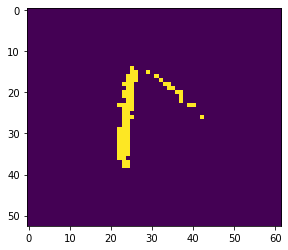

In [17]:
plt.imshow(split_by_c(points_hor, 70))

так мы теряем третью прямую - попробуем поменьше

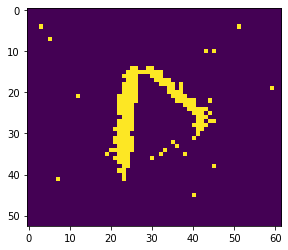

In [18]:
plt.imshow(split_by_c(points_hor, 45))

если мы всё же хотим побороться за третью прямую - думаю, это то, что нам нужно.

In [19]:
data_vert = return_train_from_ar_gradient(points_vert, 85)
data_hor = return_train_from_ar_gradient(points_hor, 45)

правда теперь я немного вручную обозначаю, где будут границы

In [20]:
#first_line_vert = data_vert[(data_vert[:, 1] < 26) & (data_vert[:, 0] < 45)]
second_line_vert = data_vert[(data_vert[:, 1] > 26) & (data_vert[:, 0] < 25)]
third_line_vert = data_vert[(data_vert[:, 1] > 26) & (data_vert[:, 0] >= 25)]

first_line_hor = data_hor[(data_hor[:, 1] < 26) & (data_hor[:, 0] < 45)]
second_line_hor = data_hor[(data_hor[:, 1] > 26) & (data_hor[:, 0] < 25)]
third_line_hor = data_hor[(data_hor[:, 1] > 26) & (data_hor[:, 0] >= 25)]

Результат вертикального градиента:

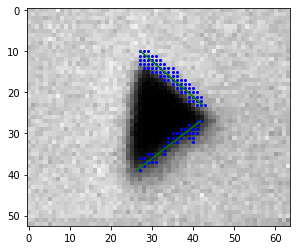

In [21]:
show_result(second_line_vert)
show_result(third_line_vert)

Вполне приемлемо, посмотрим на горизонтальный:

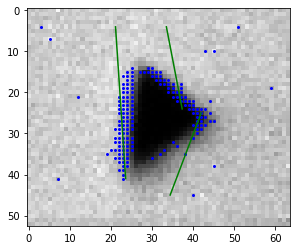

In [22]:
show_result(first_line_hor)
show_result(second_line_hor)
show_result(third_line_hor)

Результат получился таким из-за выбросов - мы поставили слишком маленький порог значения градиента, из-за чего какие-то случайные точки сильно влияют на нашу прямую - ведь мы минимизируем сумму квадратов расстояний до прямой

Я вижу два способа решения проблемы

- как-то по-другому строить прямую (нужна модель, устойчивая к выбросам)
- увеличить порог значения градиента чтобы случайные точки не попадали в выборку, с помощью которой мы строим прямую. У этого подхода есть минус - мы теряем информацию о третьей прямой

Пока я попробую второй способ для горизонтального градиента.

Было:

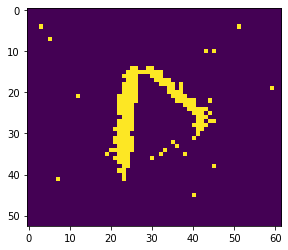

In [23]:
plt.imshow(split_by_c(points_hor, 45))

Стало:

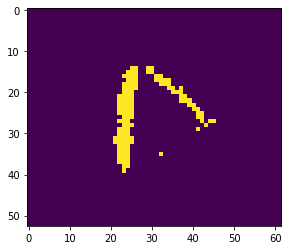

In [24]:
plt.imshow(split_by_c(points_hor, 55))

К сожалению, действительно потеряли информацию о третьей прямой

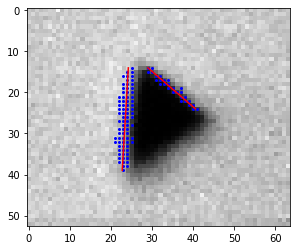

In [25]:
data_hor = return_train_from_ar_gradient(points_hor, 55)

first_line_hor = data_hor[(data_hor[:, 1] < 26) & (data_hor[:, 0] < 45)]
second_line_hor = data_hor[(data_hor[:, 1] > 26) & (data_hor[:, 0] < 25)]

show_result(first_line_hor, color='red')
show_result(second_line_hor, color='red')

Попробуем на одной картинке теперь показать и вертикальный и горизонтальный градиенты, вертикальный будет показан зелёным, горизонтальный - красным

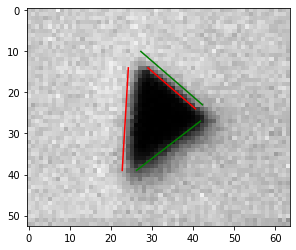

In [26]:
show_result(second_line_vert, color='green', showtrain=False)
show_result(third_line_vert, color='green', showtrain=False)

show_result(first_line_hor, color='red', showtrain=False)
show_result(second_line_hor, color='red', showtrain=False)

### Что дальше?

- попробовать то же самое на других примерах

- рассматривать для каждого пикселя сумму вертикального и горизонтального градиента. Так мы не потеряем какие-то прямые и, возможно, уменьшим шум

- рассмотреть градиент "по диагонали"

